# BERT Labeling Issue Analysis

As the result of BERT Prediction on Text Difficulity, it is found that:
 - Some similar records with different labels.
 - Some records are predicted with wrong labels without fine-tune, even after training, those still are kept as wrong labels

This notebook is used to figure out the above 2 issues.

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import torch
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE=1
#################### split data into train,dev,test##################
def train_dev_test(dataset,random_state=RANDOM_STATE):
    texts=list(dataset["original_text"])
    labels=list(dataset["label"])
    
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    print(label2idx)

    rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=RANDOM_STATE)
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=RANDOM_STATE)
    
    print("Train size:", len(train_texts))
    print("Dev size:", len(dev_texts))
    print("Test size:", len(test_texts))
    
    #Create dataframe for coming issue analysis
    df=pd.DataFrame()
    df['original_text']=train_texts+test_texts
    df['label']=train_labels+test_labels
    df['id']=df.index
    return df,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)

In [4]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

#### Prepare for data

In [5]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.01
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

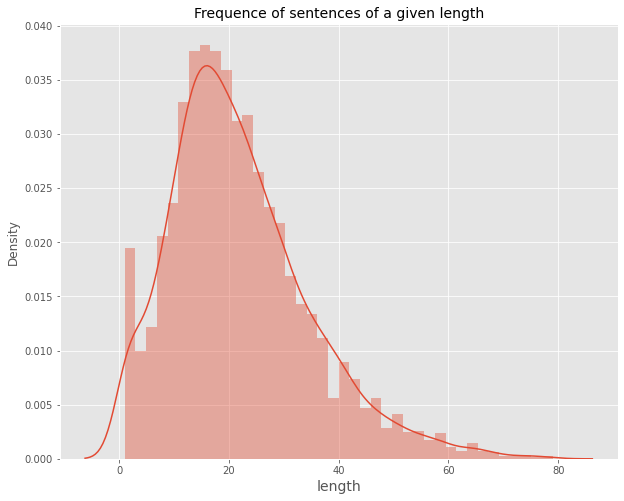

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [7]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    4168.000000
mean       21.913628
std        12.775337
min         1.000000
25%        13.000000
50%        20.000000
75%        29.000000
max        79.000000
Name: original_text, dtype: float64


In [8]:
#Create train, dev, test data
df_init,(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(train_data,random_state=RANDOM_STATE)



{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [9]:
import numpy as np
#################### Both class and the following function are used to prepare for input items##################

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items


In [71]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

#################### convert data for model input ##################

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    sample_ids=torch.tensor([j for j in range(len(features))], dtype=torch.long) #identify each record
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,sample_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

In [74]:
from tqdm import trange
from tqdm.notebook import tqdm

def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids,_ = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [12]:
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [13]:
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
from transformers import AdamW,get_linear_schedule_with_warmup
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"

In [86]:
from aum import AUMCalculator

save_dir = './tmp'
aum_calculator = AUMCalculator(save_dir, compressed=False)

In [77]:
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
model_name = "distilbert-base-uncased"

In [87]:
#def train(model_name,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params):
    
    
## Initialize bert model   
tokenizer = DistilBertTokenizer.from_pretrained(model_name,target_names=target_names)
# Using trained model
model=DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = len(target_names),
                                                         output_attentions = False,
                                                         output_hidden_states = False)  
    
## Prepare for data loading and parameter setting for bert model
train_features = convert_examples_to_inputs(train_texts,train_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
train_dataloader = get_data_loader(train_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)
dev_features = convert_examples_to_inputs(dev_texts,dev_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
dev_dataloader = get_data_loader(dev_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)

num_train_steps = int(len(train_dataloader.dataset) / params['BATCH_SIZE'] /params['GRADIENT_ACCUMULATION_STEPS'] * params['NUM_TRAIN_EPOCHS'])
num_warmup_steps = params['NUM_WARMUP_STEPS']

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=params['LEARNING_RATE'], correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)
    
##Enable GPU if has
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    
## Start to training 
torch.backends.cudnn.benchmark = True # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

loss_history = []
no_improvement = 0
PATIENCE=2
for _ in trange(int(params["NUM_TRAIN_EPOCHS"]), desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    #j=0
    #sample_ids=[]
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids,sample_ids = batch
        
        #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids) # non-distillbert
        outputs = model(input_ids, attention_mask=input_mask,labels=label_ids)
        
        records = aum_calculator.update(outputs[1], label_ids,sample_ids.tolist())
        
        loss = outputs[0]

        if params['GRADIENT_ACCUMULATION_STEPS'] > 1:
            loss = loss / params['GRADIENT_ACCUMULATION_STEPS']

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % params['GRADIENT_ACCUMULATION_STEPS'] == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(),params['MAX_GRAD_NORM'])  

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
    dev_loss, _, _ = evaluate(model, dev_dataloader)
    #print("Dev loss:", dev_loss)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)

    if len(loss_history) == 0 or dev_loss < min(loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE: 
        print("No improvement on development set. Finish training.")
        break


    loss_history.append(dev_loss)
    

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6485842193166415


Epoch:  12%|█▎        | 1/8 [00:41<04:47, 41.08s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6485842193166415]
Dev loss: 0.580960520853599


Epoch:  25%|██▌       | 2/8 [01:22<04:07, 41.21s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:03<03:26, 41.21s/it]

Loss history: [0.6485842193166415, 0.580960520853599]
Dev loss: 0.6719721698512634


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|███▊      | 3/8 [02:45<04:35, 55.00s/it]

Loss history: [0.6485842193166415, 0.580960520853599, 0.6719721698512634]
Dev loss: 0.9957805313169956
No improvement on development set. Finish training.


In [85]:
# Finalize aum calculator
aum_calculator.finalize()

In [19]:
# Evaluate the dataset based on trained distilbert model
def data_evaluation(texts,labels,model_name,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME):
    # Convert test data of submission to features
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    #BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
       
    if trained:
        # Using trained model
        model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
        model=DistilBertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)
    else:
        # Using pretrained model without training
        model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)        
    model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx,  params['MAX_SEQ_LENGTH'], tokenizer)
    dataloader = get_data_loader(features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(model, dataloader)
    print("Errors performance:", precision_recall_fscore_support(correct, predicted, average="micro"))

    bert_accuracy = np.mean(predicted == correct)
    
    #print(bert_accuracy)
    print(classification_report(correct, predicted))

    return correct,predicted, bert_accuracy 

In [20]:
_,orig_pred,orig_acc=data_evaluation(test_texts,test_labels,model_name,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6714628297362111, 0.6714628297362111, 0.6714628297362111, None)
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       196
           1       0.71      0.64      0.67       221

    accuracy                           0.67       417
   macro avg       0.67      0.67      0.67       417
weighted avg       0.68      0.67      0.67       417

